In [1]:
# conda activate net-pred
# conda deactivate

import pandas as pd
from scapy.all import rdpcap
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import weibull_min
from scipy.stats import kstest
from IPython.display import display, display_pretty

In [2]:
# Read PCAP file using Scapy
def readPCAP(pcapFile):
    packets = rdpcap(pcapFile)

    # Extract packet information
    packet_data = []
    for packet in packets:
        if 'IP' in packet:
            try:
                ip_layer = packet['IP']
                transport_layer = packet[ip_layer.payload.name]

                packet_info = {
                    'Source IP': ip_layer.src,
                    'Destination IP': ip_layer.dst,
                    'Protocol': ip_layer.payload.name,
                    'Source Port': transport_layer.sport if hasattr(transport_layer, 'sport') else None,
                    'Destination Port': transport_layer.dport if hasattr(transport_layer, 'dport') else None,
                    'Timestamp': packet.time,
                    'Packet Size': len(packet)
                }
                packet_data.append(packet_info)

            except IndexError:
                packet_info = {
                    'Source IP': ip_layer.src,
                    'Destination IP': ip_layer.dst,
                    'Protocol': ip_layer.payload.name,
                    'Source Port': None,
                    'Destination Port': None,
                    'Timestamp': packet.time,
                    'Packet Size': len(packet)
                }
                packet_data.append(packet_info)

    # Convert to Pandas DataFrame
    df = pd.DataFrame(packet_data)

    # Drop rows with NaN or None values
    df_cleaned = df.dropna()

    return df_cleaned


In [3]:
# Visualizing 3 data sources
data1 = "data/pcap/2024-dataset1/2024data_00000_20240101120000"
data2 = "data/pcap/2024-dataset1/2024data_00001_20240101120000"
data3 = "data/pcap/2024-dataset1/2024data_00002_20240101120000"

df1 = readPCAP(data1)
df2 = readPCAP(data2)
df3 = readPCAP(data3)

# Display the DataFrames side by side
display(df1, df2, df3)

,Source IP,Destination IP,Protocol,Source Port,Destination Port,Timestamp,Packet Size
0,138.77.78.189,133.228.163.72,TCP,60042.0,60000.0,1704085200.154523,58
1,185.72.152.109,150.95.99.215,UDP,34737.0,443.0,1704085200.154539,58
2,150.95.0.162,117.108.194.199,TCP,443.0,56743.0,1704085200.15454,54
5,38.186.29.190,163.93.233.130,TCP,8883.0,62913.0,1704085200.154578,54
6,185.114.41.182,163.93.99.62,TCP,60689.0,22.0,1704085200.154584,54
...,...,...,...,...,...,...,...
4208,203.141.138.107,103.221.22.137,TCP,873.0,37068.0,1704085200.195153,66
4209,101.158.232.70,157.174.232.5,UDP,52189.0,443.0,1704085200.195154,58
4210,133.251.157.235,54.37.215.143,TCP,53912.0,443.0,1704085200.19516,66
4211,103.132.254.160,202.197.88.34,UDP,20464.0,53.0,1704085200.195184,54


,Source IP,Destination IP,Protocol,Source Port,Destination Port,Timestamp,Packet Size
0,133.251.24.132,91.188.255.84,TCP,80.0,51076.0,1704085200.195205,54
1,60.249.157.134,150.95.0.162,TCP,62985.0,443.0,1704085200.195208,54
2,133.251.24.132,91.188.255.84,TCP,80.0,51076.0,1704085200.195209,54
3,205.4.59.177,203.141.136.187,UDP,53.0,44633.0,1704085200.195212,54
4,223.183.71.33,150.95.0.162,TCP,24130.0,443.0,1704085200.195224,90
...,...,...,...,...,...,...,...
4489,1.139.18.71,163.93.122.13,TCP,63694.0,2323.0,1704085200.234295,54
4491,101.158.232.70,157.174.232.5,UDP,52189.0,443.0,1704085200.234301,58
4492,150.95.0.162,124.31.143.200,TCP,443.0,62844.0,1704085200.23432,54
4493,157.174.255.228,112.72.188.145,UDP,8054.0,58272.0,1704085200.234322,42


,Source IP,Destination IP,Protocol,Source Port,Destination Port,Timestamp,Packet Size
1,129.239.9.55,150.95.110.212,TCP,80.0,52307.0,1704085200.234334,54
4,193.249.8.64,163.93.11.247,TCP,48687.0,4444.0,1704085200.234355,54
5,150.95.0.162,124.31.143.200,TCP,443.0,62844.0,1704085200.234362,54
6,126.175.247.190,131.116.149.90,UDP,4500.0,4500.0,1704085200.234363,42
7,24.55.107.79,203.141.139.166,TCP,51888.0,53.0,1704085200.234395,66
...,...,...,...,...,...,...,...
4469,61.188.221.144,150.95.109.3,TCP,32165.0,8536.0,1704085200.274925,54
4470,150.95.110.50,61.29.232.81,TCP,50697.0,443.0,1704085200.274986,54
4471,133.232.88.108,123.241.233.239,TCP,9632.0,49493.0,1704085200.274987,74
4473,203.141.136.65,54.1.194.102,TCP,56494.0,443.0,1704085200.275013,54


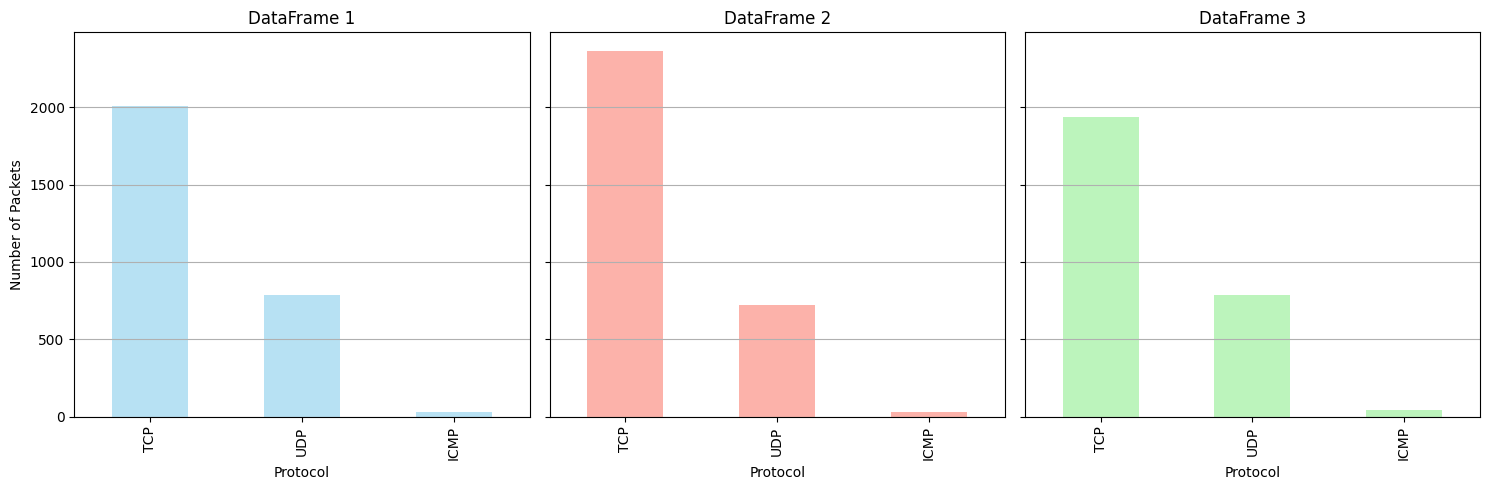

In [4]:
# Count the number of packets for each protocol
def plotProtocols(dataframes, labels):
    fig, axs = plt.subplots(1, 3, figsize=(
        15, 5), sharey=True)  # Create three subplots

    # Define colors for each DataFrame
    colors = ['skyblue', 'salmon', 'lightgreen']

    for df, label, color, ax in zip(dataframes, labels, colors, axs):
        protocol_counts = df['Protocol'].value_counts()
        protocol_counts.plot(kind='bar', color=color, alpha=0.6, ax=ax)
        ax.set_title(label)
        ax.set_xlabel('Protocol')
        ax.set_ylabel('Number of Packets')
        ax.grid(axis='y')

    plt.tight_layout()
    plt.show()


# Call the function with the list of dataframes and labels
plotProtocols([df1, df2, df3], ['DataFrame 1', 'DataFrame 2', 'DataFrame 3'])

In [5]:
# Extracting only the TCP packets
import pandas as pd
import matplotlib.pyplot as plt
def extractTCP(df):
    tcp_df = df[df['Protocol'] == 'TCP']
    tcp_df = tcp_df.reset_index(drop=True)
    return tcp_df


tcp_df1 = extractTCP(df1)
tcp_df2 = extractTCP(df2)
tcp_df3 = extractTCP(df3)

# Call the function with the DataFrames
display(tcp_df1, tcp_df2, tcp_df3)

,Source IP,Destination IP,Protocol,Source Port,Destination Port,Timestamp,Packet Size
0,138.77.78.189,133.228.163.72,TCP,60042.0,60000.0,1704085200.154523,58
1,150.95.0.162,117.108.194.199,TCP,443.0,56743.0,1704085200.15454,54
2,38.186.29.190,163.93.233.130,TCP,8883.0,62913.0,1704085200.154578,54
3,185.114.41.182,163.93.99.62,TCP,60689.0,22.0,1704085200.154584,54
4,157.174.18.145,144.66.254.210,TCP,62574.0,8080.0,1704085200.154597,54
...,...,...,...,...,...,...,...
2002,185.47.148.134,150.95.63.94,TCP,37609.0,30007.0,1704085200.19512,54
2003,60.249.157.134,150.95.0.162,TCP,62985.0,443.0,1704085200.195132,54
2004,192.105.43.51,203.141.143.26,TCP,443.0,54554.0,1704085200.195145,54
2005,203.141.138.107,103.221.22.137,TCP,873.0,37068.0,1704085200.195153,66


,Source IP,Destination IP,Protocol,Source Port,Destination Port,Timestamp,Packet Size
0,133.251.24.132,91.188.255.84,TCP,80.0,51076.0,1704085200.195205,54
1,60.249.157.134,150.95.0.162,TCP,62985.0,443.0,1704085200.195208,54
2,133.251.24.132,91.188.255.84,TCP,80.0,51076.0,1704085200.195209,54
3,223.183.71.33,150.95.0.162,TCP,24130.0,443.0,1704085200.195224,90
4,162.46.126.204,203.141.138.107,TCP,17617.0,80.0,1704085200.195228,66
...,...,...,...,...,...,...,...
2362,163.93.40.237,170.90.225.31,TCP,51067.0,443.0,1704085200.234278,66
2363,150.95.0.162,124.31.143.200,TCP,443.0,62844.0,1704085200.23429,54
2364,1.139.18.71,163.93.122.13,TCP,63694.0,2323.0,1704085200.234295,54
2365,150.95.0.162,124.31.143.200,TCP,443.0,62844.0,1704085200.23432,54


,Source IP,Destination IP,Protocol,Source Port,Destination Port,Timestamp,Packet Size
0,129.239.9.55,150.95.110.212,TCP,80.0,52307.0,1704085200.234334,54
1,193.249.8.64,163.93.11.247,TCP,48687.0,4444.0,1704085200.234355,54
2,150.95.0.162,124.31.143.200,TCP,443.0,62844.0,1704085200.234362,54
3,24.55.107.79,203.141.139.166,TCP,51888.0,53.0,1704085200.234395,66
4,24.55.107.79,203.141.139.166,TCP,51888.0,53.0,1704085200.234397,66
...,...,...,...,...,...,...,...
1932,61.188.221.144,150.95.109.3,TCP,32165.0,8536.0,1704085200.274925,54
1933,150.95.110.50,61.29.232.81,TCP,50697.0,443.0,1704085200.274986,54
1934,133.232.88.108,123.241.233.239,TCP,9632.0,49493.0,1704085200.274987,74
1935,203.141.136.65,54.1.194.102,TCP,56494.0,443.0,1704085200.275013,54


In [6]:
# Finding the number of packets sent between each source and destination
def grpBySrcDest(df):
    packet_counts = df.groupby(
        ['Source IP', 'Destination IP']).size().reset_index(name='Packet Count')

    # Sorting by descending order of source and desination packets
    packet_counts_sorted = packet_counts.sort_values(
        by='Packet Count', ascending=False)
    
    # Get the first row of the DataFrame
    max_row = packet_counts_sorted.iloc[0]

    # Extract the source and destination IP addresses from the first row
    source_ip = max_row['Source IP']
    destination_ip = max_row['Destination IP']
    print(source_ip, destination_ip)
    
    return packet_counts_sorted, source_ip, destination_ip


count_df1, src1, dest1 = grpBySrcDest(tcp_df1)
count_df2, src2, dest2 = grpBySrcDest(tcp_df2)
count_df3, src3, dest3 = grpBySrcDest(tcp_df3)

# Call the function with the DataFrames
display(count_df1, count_df2, count_df3)

216.100.199.237 150.95.0.162
52.198.12.253 150.95.182.197
150.95.110.50 61.29.232.81


,Source IP,Destination IP,Packet Count
564,216.100.199.237,150.95.0.162,117
101,129.239.9.55,150.95.110.212,84
719,52.198.12.253,150.95.182.197,74
425,185.130.78.90,150.95.0.162,71
186,150.95.172.72,218.80.88.241,61
...,...,...,...
347,167.249.122.146,163.93.82.222,1
348,167.249.122.148,133.228.42.206,1
349,167.249.122.149,150.95.208.206,1
350,167.249.122.150,163.93.173.204,1


,Source IP,Destination IP,Packet Count
732,52.198.12.253,150.95.182.197,320
174,150.95.110.48,156.56.66.111,152
98,129.239.9.55,150.95.110.212,74
181,150.95.172.72,218.80.88.241,71
414,185.130.78.90,150.95.0.162,65
...,...,...,...
357,167.65.105.75,163.93.224.44,1
358,167.65.106.68,163.93.170.20,1
359,167.65.106.79,203.141.151.94,1
360,167.65.117.147,150.95.244.221,1


,Source IP,Destination IP,Packet Count
160,150.95.110.50,61.29.232.81,151
91,129.239.9.55,150.95.110.212,77
732,61.188.221.144,150.95.109.3,70
731,60.249.157.134,150.95.0.162,62
400,185.130.78.90,150.95.0.162,50
...,...,...,...
347,167.65.117.158,203.141.196.83,1
348,167.65.117.74,133.228.20.174,1
349,167.65.117.76,203.141.186.126,1
350,167.65.117.83,133.228.45.90,1


In [16]:
# Define the source and destination IP addresses you want to filter for
def displaySrcDestTraffic(df, src, dest):
    # Filter DataFrame for rows with specific source and destination IP addresses
    filtered_rows = df[(df['Source IP'] == src) & (
        df['Destination IP'] == dest)]

    filtered_rows = filtered_rows.reset_index(drop=True)

    return filtered_rows


filtered_df1 = displaySrcDestTraffic(tcp_df1, src1, dest1)
filtered_df2 = displaySrcDestTraffic(tcp_df2, src2, dest2)
filtered_df3 = displaySrcDestTraffic(tcp_df3, src3, dest3)

display(filtered_df1, filtered_df3)

,Source IP,Destination IP,Protocol,Source Port,Destination Port,Timestamp,Packet Size
0,216.100.199.237,150.95.0.162,TCP,873.0,49948.0,1704085200.159438,66
1,216.100.199.237,150.95.0.162,TCP,873.0,49948.0,1704085200.159539,66
2,216.100.199.237,150.95.0.162,TCP,873.0,49948.0,1704085200.163491,66
3,216.100.199.237,150.95.0.162,TCP,873.0,49948.0,1704085200.163494,66
4,216.100.199.237,150.95.0.162,TCP,873.0,49948.0,1704085200.163524,66
...,...,...,...,...,...,...,...
112,216.100.199.237,150.95.0.162,TCP,873.0,49948.0,1704085200.177888,66
113,216.100.199.237,150.95.0.162,TCP,873.0,49948.0,1704085200.178399,66
114,216.100.199.237,150.95.0.162,TCP,873.0,49948.0,1704085200.178403,66
115,216.100.199.237,150.95.0.162,TCP,873.0,49948.0,1704085200.178518,66


,Source IP,Destination IP,Protocol,Source Port,Destination Port,Timestamp,Packet Size
0,150.95.110.50,61.29.232.81,TCP,50697.0,443.0,1704085200.237314,54
1,150.95.110.50,61.29.232.81,TCP,50697.0,443.0,1704085200.237532,54
2,150.95.110.50,61.29.232.81,TCP,50697.0,443.0,1704085200.237757,54
3,150.95.110.50,61.29.232.81,TCP,50697.0,443.0,1704085200.238019,54
4,150.95.110.50,61.29.232.81,TCP,50697.0,443.0,1704085200.238238,54
...,...,...,...,...,...,...,...
146,150.95.110.50,61.29.232.81,TCP,50697.0,443.0,1704085200.274,54
147,150.95.110.50,61.29.232.81,TCP,50697.0,443.0,1704085200.274248,54
148,150.95.110.50,61.29.232.81,TCP,50697.0,443.0,1704085200.27454,54
149,150.95.110.50,61.29.232.81,TCP,50697.0,443.0,1704085200.274723,54


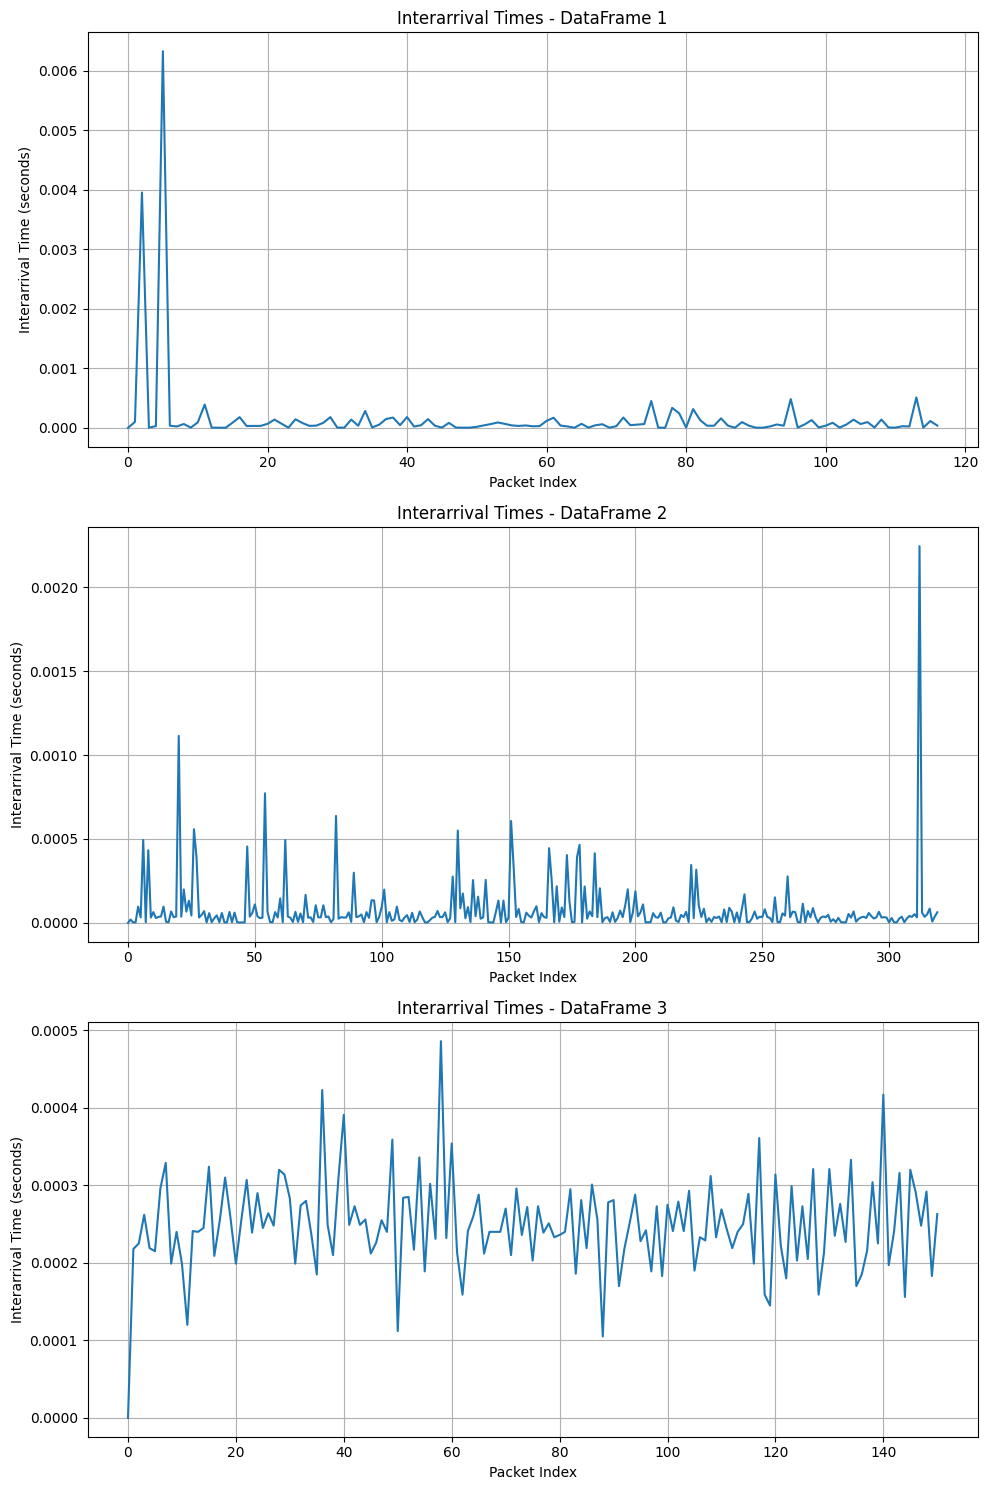

In [8]:
# Calculate packet interarrival time
# def displayIAT(df):
#     df['Interarrival Time'] = df['Timestamp'].diff()

#     # Set the first interarrival time to be 0
#     df.at[df.index[0], 'Interarrival Time'] = 0

#     # Reset index
#     df.reset_index(drop=True, inplace=True)

#     # Plot the interarrival times
#     plt.plot(df['Interarrival Time'])
#     plt.title('Interarrival Times')
#     plt.xlabel('Packet Index')
#     plt.ylabel('Interarrival Time (seconds)')
#     plt.grid(True)
#     plt.show()


def displayIAT_multiple(dfs):
    num_plots = len(dfs)
    fig, axs = plt.subplots(num_plots, figsize=(10, 5*num_plots))

    for i, df in enumerate(dfs):
        df['Interarrival Time'] = df['Timestamp'].diff()
        df.at[df.index[0], 'Interarrival Time'] = 0
        df.reset_index(drop=True, inplace=True)

        axs[i].plot(df['Interarrival Time'])
        axs[i].set_title(f'Interarrival Times - DataFrame {i+1}')
        axs[i].set_xlabel('Packet Index')
        axs[i].set_ylabel('Interarrival Time (seconds)')
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()


# Call the function with a list of DataFrames
displayIAT_multiple([filtered_df1, filtered_df2, filtered_df3])

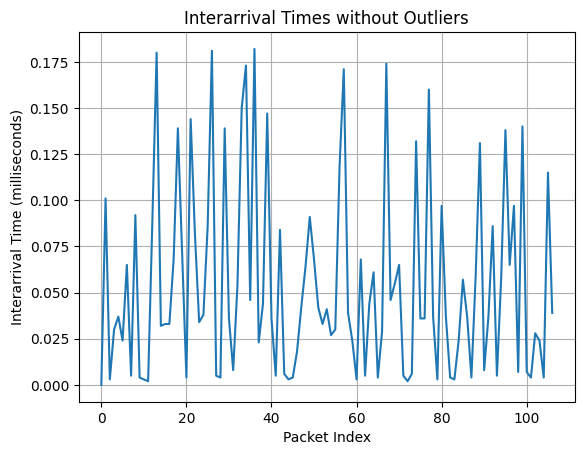

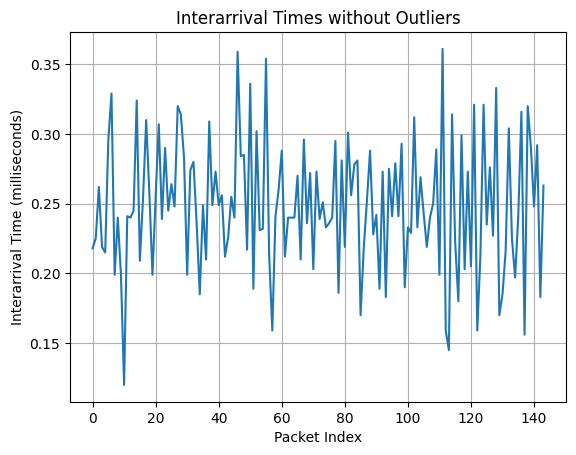

In [15]:
# Removal of outliers
def removeOutliers(df):
    # Calculate interquartile range (IQR)
    Q1 = df['Interarrival Time'].quantile(0.25)
    Q3 = df['Interarrival Time'].quantile(0.75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outlier detection
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out outliers
    df_no_outliers = df[(df['Interarrival Time'] >= lower_bound) & (
        df['Interarrival Time'] <= upper_bound)]
    
    df_no_outliers

    return df_no_outliers


def plotCleanedGraph(df):
    # Plot the interarrival times without outliers
    plt.plot(df['Interarrival Time'] * 1000)
    plt.title('Interarrival Times without Outliers')
    plt.xlabel('Packet Index')
    plt.ylabel('Interarrival Time (milliseconds)')
    plt.grid(True)
    plt.show()



cleaned_filtered_df1 = removeOutliers(filtered_df1)
cleaned_filtered_df2 = removeOutliers(filtered_df2)
cleaned_filtered_df3 = removeOutliers(filtered_df3)

cleaned_filtered_df1 = cleaned_filtered_df1.reset_index(drop=True)
cleaned_filtered_df2 = cleaned_filtered_df2.reset_index(drop=True)
cleaned_filtered_df3 = cleaned_filtered_df3.reset_index(drop=True)

# display(cleaned_filtered_df1, cleaned_filtered_df2, cleaned_filtered_df3)

cleaned_filtered_df3

# Assuming your dataframe is named df and the columns are named 'SourcePort' and 'DestPort'
# port_pairs = cleaned_filtered_df2['Source Port'].astype(
#     str) + '-' + cleaned_filtered_df2['Destination Port'].astype(str)
# same_port_pairs = len(port_pairs.unique()) == 1

# if same_port_pairs:
#     print("All source and destination port pairs in the dataframe are the same.")
# else:
#     print("There are different source and destination port pairs in the dataframe.")


plotCleanedGraph(cleaned_filtered_df1)
# plotCleanedGraph(cleaned_filtered_df2)
plotCleanedGraph(cleaned_filtered_df3)

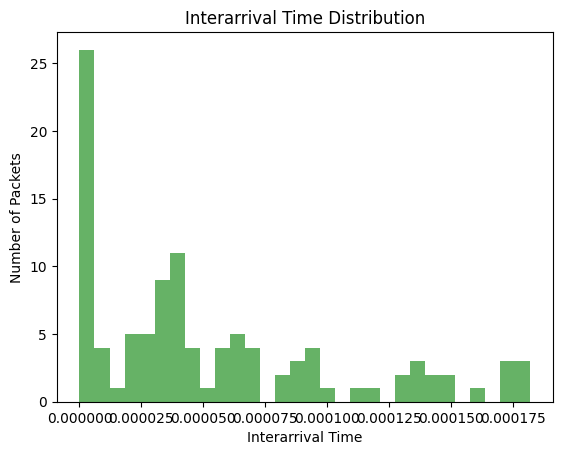

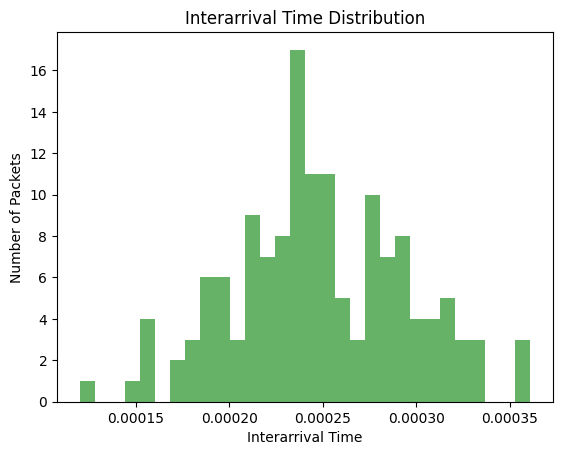

In [10]:
# def plotIATDist(df):
    # data = df

    # # Calculate histogram data
    # hist, bins = np.histogram(np.array(data['Interarrival Time'], dtype=float), bins=30)

    # # Plot bar plot
    # plt.bar(bins[:-1], hist, width=np.diff(bins), alpha=0.6, color='g')

    # # Add labels and title
    # plt.xlabel('Interarrival Time')
    # plt.ylabel('Number of Packets')
    # plt.title('Interarrival Time Distribution')

    # # Show plot
    # plt.show()

def plotIATDist(df):
    # Calculate histogram data
    data = df
    plt.hist(np.array(data['Interarrival Time'], dtype=float),
             bins=30, alpha=0.6, color='g')  # Plot histogram with 30 bins

    # Add labels and title
    plt.xlabel('Interarrival Time')
    plt.ylabel('Number of Packets')
    plt.title('Interarrival Time Distribution')

    # Show plot
    plt.show()

plotIATDist(cleaned_filtered_df1)
# plotIATDist(cleaned_filtered_df2)
plotIATDist(cleaned_filtered_df3)

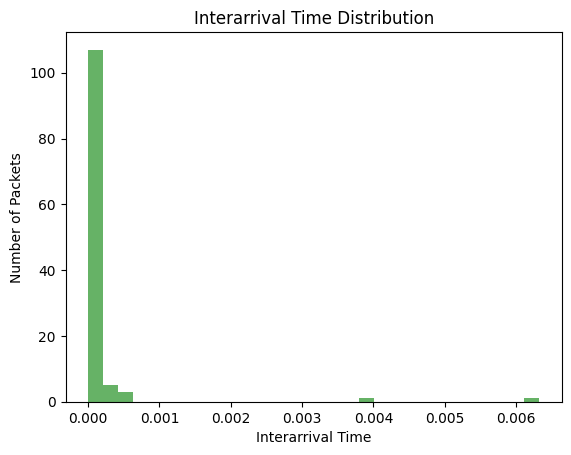

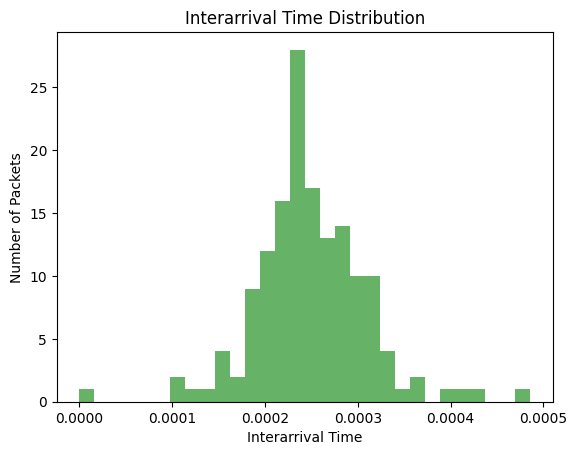

In [11]:
plotIATDist(filtered_df1)
# plotIATDist(filtered_df2)
plotIATDist(filtered_df3)

In [12]:
# Plotting against weibull distribution
import numpy as np
import scipy.stats as stats


def fit_weibull_distribution(interarrival_times):
    interarrival_times = np.array(interarrival_times, dtype=float)
    # Fit a Weibull distribution to the interarrival time data
    shape, loc, scale = stats.weibull_min.fit(interarrival_times, floc=0)

    # Create a Weibull distribution object with the fitted parameters
    weibull_dist = stats.weibull_min(shape, loc=loc, scale=scale)

    return weibull_dist

df1_weibull = fit_weibull_distribution(cleaned_filtered_df1['Interarrival Time'])
# df2_weibull = fit_weibull_distribution(cleaned_filtered_df2['Interarrival Time'].values)
df3_weibull = fit_weibull_distribution(
    cleaned_filtered_df3['Interarrival Time'].values)

/home/ce-intern/Desktop/network_time_prediction/network-pred/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:2511: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))


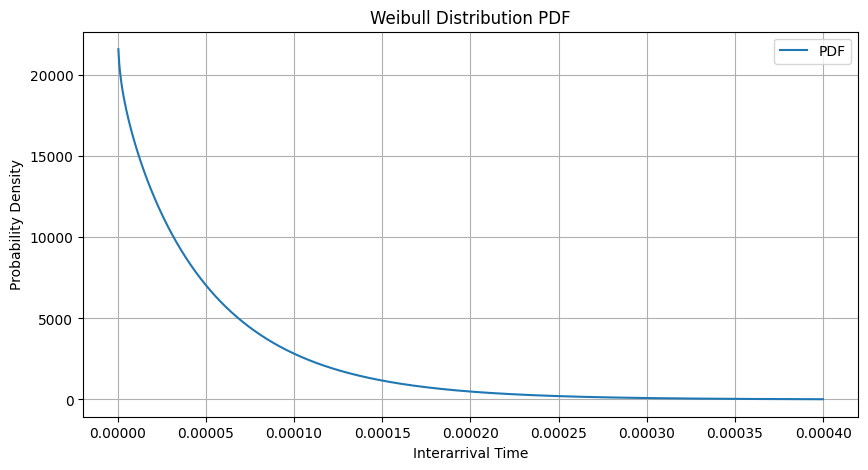

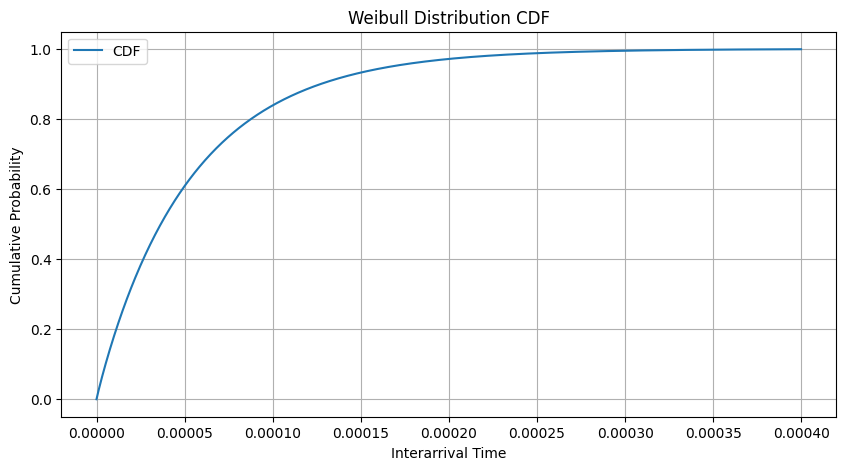

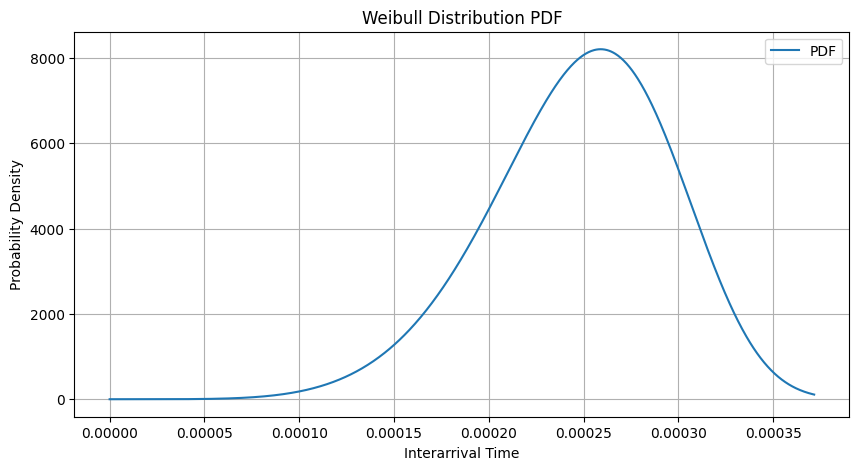

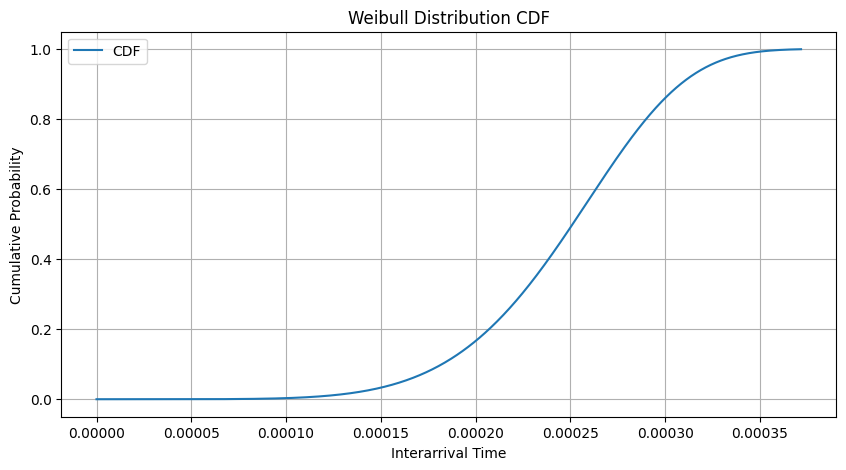

In [13]:
def plot_weibull_distribution(weibull_dist):
    # Generate interarrival times from the fitted Weibull distribution
    x = np.linspace(0, weibull_dist.ppf(0.999), 1000)
    
    # Plot the PDF
    plt.figure(figsize=(10, 5))
    plt.plot(x, weibull_dist.pdf(x), label='PDF')
    plt.title('Weibull Distribution PDF')
    plt.xlabel('Interarrival Time')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot the CDF
    plt.figure(figsize=(10, 5))
    plt.plot(x, weibull_dist.cdf(x), label='CDF')
    plt.title('Weibull Distribution CDF')
    plt.xlabel('Interarrival Time')
    plt.ylabel('Cumulative Probability')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# plot_weibull_distribution(weibull_dist)

plot_weibull_distribution(df1_weibull)
# plot_weibull_distribution(df2_weibull)
plot_weibull_distribution(df3_weibull)